# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 24 марта 18:00 Сдача **очная** на занятии. <br\>


Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Здравствуйте, уважаемые студенты! 

В этом задании мы будем реализовать линейные модели. Необходимо реализовать линейную и логистическую регрессии с L2 регуляризацией

# Теоретическое введение



Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE 

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Не забываем, что здесь и далее  мы считаем, что в $x_i$ есть тождественный вектор единиц, ему соответствует вес $w_0$.


Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической: 
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту $L2$ регуляризацию.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    


# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Градиент для линейной регрессии.
* Выпишите формулу обновления весов для линейной регрессии с L2 регуляризацией для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент?

***Ваше решение здесь***

$$Q_{r} = Q(w) + \dfrac{1}{C}*R(w) = Q(w) + \dfrac{1}{C}* \sum_{i=1}^{D} w_{i}^{2}$$

$$ w_{new} = w_{old} - \alpha*\nabla_{w}Q_{r}(w_{old}) = w_{old}\left(1-\dfrac{2\alpha}{C}\right) - \dfrac{2\alpha}{n}\sum_{j=1}^{n}(x_{j}*w_{old}-y_{j})*x_{j}$$

Задача 2. Градиент для логистической регрессии.
* Выпишите формулу обновления весов для логистической регрессии с L2 регуляризацией  для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент? Как соотносится этот градиент с градиентом, возникающий в задаче линейной регрессии?

Подсказка: Вам градиент, которой получается если “в лоб” продифференцировать,  надо немного преобразовать.
Надо подставить, что $1 - \sigma(w,x) $ это  $1 - a(x_i)$, а  $-\sigma(w,x)$ это $0 - a(x_i)$.  Тогда получится свести к одной красивой формуле с линейной регрессией, которую программировать будет намного проще.

***Ваше решение здесь***

$$ \nabla \left[\sum_i y_i \log \sigma(w,x_i) + ( 1 - y_i) \log (1 - \sigma(w,x_i)) \right] = \left[ \dfrac{y_i*\sigma(w,x_i)(1-\sigma(w,x_i))}{\sigma(w,x_i)} - \dfrac{(1-y_i)\sigma(w,x_i)(1-\sigma(w,x_i))}{(1-\sigma(w,x_i))} \right] * x_i = - (y_i - \sigma(w,x_i)) * x_i $$

$$ w_{new} = w_{old} - \alpha*\nabla_{w}Q_{r}(w_{old}) =  w_{old}\left(1-\dfrac{2\alpha}{C}\right) - \dfrac{\alpha}{n}\sum_{i=1}^{n} (\sigma(w,x_i) - y_i) * x_i $$

Задача 3. Точное решение линейной регрессии

На лекции было показано, что точное решение линейной регрессии имеет вид $w = (X^TX)^{-1}X^TY $. 
* Покажите, что это действительно является точкой минимума в случае, если матрица X имеет строк не меньше, чем столбцов и имеет полный ранг. Подсказка: посчитайте Гессиан и покажите, что в этом случае он положительно определен. 
* Выпишите точное решение для модели с $L2$ регуляризацией. Как L2 регуляризация помогает с точным решением где матрица X имеет линейно зависимые признаки?

***Ваше решение здесь***

$$ Q(w) = \dfrac{1}{N} (w^{T}X^{T}Xw - w^{T}X^{T}y - y^{T}Xw + y^{T}y) $$

$$ H(f(w))=\left(\begin{array}{cccc}
\frac{\partial^{2} f(x)}{\partial w_{0}^{2}} & \frac{\partial^{2} f(x)}{\partial w_{0} \partial w_{1}} & \cdots & \frac{\partial^{2} f(x)}{\partial w_{0} \partial w_{D}} \\
\frac{\partial^{2} f(x)}{\partial w_{1} \partial w_{0}} & \frac{\partial^{2} f(x)}{\partial w_{1}^{2}} & \cdots & \frac{\partial^{2} f(x)}{\partial w_{1} \partial w_{D}} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial^{2} f(x)}{\partial w_{D} \partial w_{0}} & \frac{\partial^{2} f(x)}{\partial w_{D} \partial w_{1}} & \cdots & \frac{\partial^{2} f(x)}{\partial w_{D}^{2}}
\end{array}\right) $$

$$ H(Q(w))= \frac{2}{N} \left(\begin{array}{cccc}
x_{0}^{T} x_{0} &  x_{0}^{T} x_{1} & \dots &  x_{0}^{T} x_{D} \\
x_{0}^{T} x_{1} &  x_{1}^{T} x_{1} & \dots & x_{1}^{T} x_{D} \\
\vdots & \vdots & \ddots & \vdots \\
 x_{D}^{T} x_{0} &  x_{D}^{T} x_{1} & \dots &  x_{D}^{T} x_{D}
\end{array}\right)  =  \frac{2}{N} X^{T} X $$

Матрица A положительно определена тогда и только тогда, когда $ \exists B: A = B^{T}*B $. Гессиан Q(w) положительно определён, так как $\exists B = \sqrt{\dfrac{2}{N}}* X : H(Q(w)) = B^{T} B$

Точное решение для линейной регрессии:

$$ \omega=\left(X^{T} X\right)^{-1} X^{T} y $$

Точное решение для L2-регуляризации:

$$ \omega=\left(X^{T} X+\lambda I\right)^{-1} X^{T} y$$

Если у матрицы X есть линейно зависимые строки, то и ранг произведения $ X^{T} X $ будет меньше размерности получившейся матрицы, потому что ранг произведения матриц не превышает ранга каждого из сомножителей. Следовательно, $ X^{T} X $ вырожденна, и обратной для неё не существует.

При регуляризации мы частично боремся с этой проблемой путём добавления $\lambda I$. В машинном обучении обычно имеют дело с большими размерностями X, поэтому вероятность, что добавление $\lambda I$ понизит, а не повысит ранг, мала. Поэтому так мы можем справиться с проблемой необратимости матрицы при наличии линейно зависимых признаков.

Задача 4.  Предсказываем вероятности.

Когда говорят о логистической регрессии, произносят фразу, что она "предсказывает вероятности положительного класса". Давайте разберемся, что же за этим стоит. Посчитаем математическое ожидание функции потерь и проверим, что предсказание алгоритма, оптимизирующее это мат. ожидание, будет являться вероятностью положительного класса. 

И так, функция потерь на объекте $x_i$, который имеет метку $y_i \in \{0,1\}$  для предсказания $a(x_i)$ равна:
$$L(y_i, b) =-[y_i == 1] \log a(x_i)  - [y_i == 0] \log(1 - a(x_i)) $$

Где $[]$ означает индикатор $-$ он равен единице, если значение внутри него истинно, иначе он равен нулю. Тогда мат. ожидание при условии конкретного $x_i$  по определение мат. ожидания дискретной случайной величины:
$$E(L | x_i) = -p(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i))$$
* Докажите, что значение $a(x_i)$, минимизирующее данное мат. ожидание, в точности равно $p(y_i = 1 |x_i)$, то есть равно вероятности положительного класса.

Подсказка: возможно, придется воспользоваться, что  $p(y_i = 1 | x_i) + p(y_i = 0 | x_i) = 1$

***Ваше решение здесь***

Чтобы найти значение $a(x_i)$, минимизирующее мат. ожидание, продифференцируем мат. ожидание и приравняем результат к нулю. Для краткости записи обозначим $p(y_i = 1 | x_i) = p,  p(y_i = 0 | x_i) = q, a(x_i) = a$ 

$$ E(L | x_i)' = -p * \dfrac{1}{a} a' + q*\dfrac{1}{1-a} a' = 0 $$

$$ -p * \dfrac{1}{a} + (1-p) *\dfrac{1}{1-a} = 0 $$

$$ -p(1-a)+a-pa = 0 $$

$$ a = p $$

Задача 5.  Смысл регуляризации.

Нужно ли в L1/L2 регуляризации использовать свободный член $w_0$ (который не умножается ни на какой признак)?

Подсказка: подумайте, для чего мы вводим $w_0$

***Ваше решение здесь***

Нет, не нужно

Рассмотрим ситуацию:

$ Y = WX + a $

$ Y' = Y + 5 $

Если мы будем использовать в регуляризации свободный член, то Y' мы будем штрафовать больше, что не обоснованно. 

Можно подумать, как можно было бы применить к свободному члену свой собственный коэффициент регуляризации...

Мало ли, если нам очень понадобится

#  Реализация линейной модели (4 балла)

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. Ниже Вы можете насладиться  генератором чисел Фибоначчи.

In [2]:
def fib(max_iter=4):
    a, b = 0, 1
    iter_num = 0
    while 1:
        yield a
        a, b = b, a + b
        iter_num += 1
        if iter_num == max_iter:
            break

Вот так можно сгенерировать последовательность Фибоначчи. 

Заметьте, что к генераторам можно применять некоторые стандартные функции из Python, например enumerate.

In [3]:
new_generator = fib()
for j, fib_val in enumerate(new_generator):
    print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Пересоздавая объект, можно сколько угодно раз генерировать заново последовательность. 

In [4]:
for i in range(0, 3):
    new_generator = fib()
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


А вот так уже нельзя.

In [5]:
new_generator = fib()
for i in range(0, 3):
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [6]:
from sklearn import utils

In [7]:
def batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
    if shuffle:
        X_batch, y_batch = utils.shuffle(X, y, random_state=0)
    else:
        X_batch, y_batch = X, y
    
    for i in range(0, y.shape[0], batch_size):
        X_batch = X[i: i + batch_size]
        y_batch = y[i: i + batch_size]
        yield (X_batch, y_batch)

# Теперь можно сделать генератор по данным ()
#  my_batch_generator = batch_generator(X, y, shuffle=True, batch_size=1):

In [8]:
np.log(1)

0.0

In [9]:
#%%pycodestyle

def sigmoid(x):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """
    return 1/(1 + np.exp(-x))

from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, batch_generator, C=1, alpha=0.01, max_epoch=10, batch_size=1, model_type='lin_reg'):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        """
        
        self.C = C
        self.alpha = alpha
        self.batch_size = batch_size
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter' : [], 'loss' : []}  
        self.model_type = model_type
        
    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу 
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        N = X_batch.shape[0]
        
        if self.model_type == 'lin_reg':
            loss = 1/N * (y_batch - np.dot(X_batch, self.weights))**2
        
        if self.model_type == 'log_reg':
            a = sigmoid(np.dot(X_batch, self.weights))
            loss = -1/N * (y_batch * np.log(a) + (1 - y_batch) * np.log(1 - a))
        
        loss += np.linalg.norm(self.weights) / self.C
        return loss
    
    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        N = X_batch.shape[0]
        
        if self.model_type == 'lin_reg':
            loss_grad = 2/N * np.dot( np.dot(X_batch, self.weights) - y_batch, X_batch )
            
        if self.model_type == 'log_reg':
            a = sigmoid(np.dot(X_batch, self.weights))
            loss_grad = 1/N * np.dot(a - y_batch, X_batch)
        
        loss_grad += self.weights * 2 / self.C
        return loss_grad
    
    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        self.weights -= self.alpha * new_grad
    
    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''
        # Нужно инициализровать случайно веса
        self.weights = np.random.uniform(0, 42, size=X.shape[1]).astype(np.float64)
        for n in range(0, self.max_epoch):
            new_epoch_generator = self.batch_generator(X, y, shuffle=True, batch_size=self.batch_size)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1]
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                self.update_weights(batch_grad)
                # Подумайте в каком месте стоит посчитать ошибку для отладки модели
                # До градиентного шага или после
                batch_loss = self.calc_loss(X_batch, y_batch)
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)
                
        return self
        
    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''
        if self.model_type == 'lin_reg':
            y_hat = np.dot(X, self.weights)
        if self.model_type == 'log_reg':
            y_hat = sigmoid( np.dot(X, self.weights) )
        
        return y_hat

Запустите обе регрессии на синтетических данных. 


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [10]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [11]:
def plot_decision_boundary(clf):
    x = np.linspace(-5,8)
    y = -x * clf.weights[0] / clf.weights[1]
    plt.plot(x, y)
    plt.xlim(-4, 4)
    plt.ylim(-5, 5)

In [12]:
def plot_decision_boundary_sk(clf):
    x = np.linspace(-5,8)
    y = -x * clf.coef_[0][0] / clf.coef_[0][1]
    plt.plot(x, y)
    plt.xlim(-4, 4)
    plt.ylim(-5, 5)

In [13]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X_g = np.vstack([gauss1, gauss2])
y_g = np.r_[np.ones(200), np.zeros(200)]

In [14]:
#numpy.random.randn генерирует стандартное нормальное распределение, которое мы потом изменяем
#почему бы его не стандартизовать?
skaler = StandardScaler()
X_g = skaler.fit_transform(X_g)

In [15]:
clf_lin = MySGDClassifier(batch_generator, C=1, alpha=0.01, max_epoch=100, model_type='lin_reg')
clf_log = MySGDClassifier(batch_generator, C=1, alpha=0.01, max_epoch=100, model_type='log_reg')
clf_lin_sk = SGDClassifier()
clf_lin_sk = SGDClassifier()
clf_log_sk = SGDClassifier(loss='log')
clf_log_sk = SGDClassifier()
#my_clf = MySGDClassifier(batch_generator, C=best_C, alpha=best_alpha, max_epoch=best_max_epoch, model_type=best_model_type, batch_size=batch_size)
clf_lin_sk.fit(X_g, y_g)
clf_log_sk.fit(X_g, y_g)
clf_lin.fit(X_g, y_g)
clf_log.fit(X_g, y_g)
#my_clf.fit(X_g, y_g)

/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log
/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in multiply


MySGDClassifier(C=1, alpha=0.01,
                batch_generator=<function batch_generator at 0x91f3d7d08>,
                batch_size=1, max_epoch=100, model_type='log_reg')

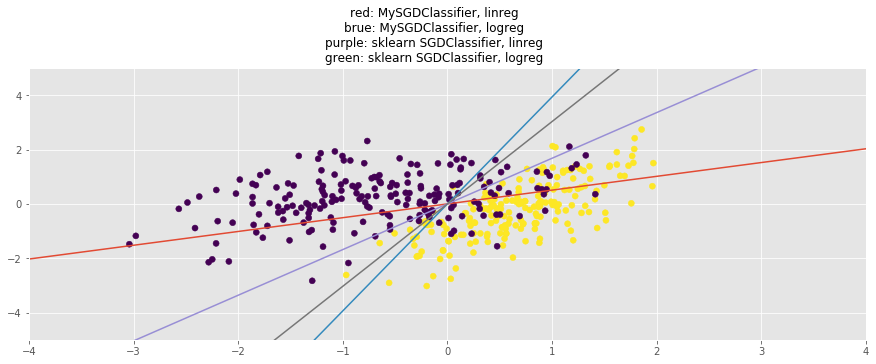

In [16]:
fig = plt.figure(figsize=(15,5))
ttl = fig.suptitle('red: MySGDClassifier, linreg\n'+
                   'brue: MySGDClassifier, logreg\n'+
                   'purple: sklearn SGDClassifier, linreg\n'+
                   'green: sklearn SGDClassifier, logreg')
ttl.set_position([.5, 1.05])
plot_decision_boundary(clf_lin)
plot_decision_boundary(clf_log)
plot_decision_boundary_sk(clf_lin_sk)
plot_decision_boundary_sk(clf_log_sk)
#plot_decision_boundary(my_clf)
plt.scatter(X_g[:,0], X_g[:,1], c=y_g)
plt.show()

То, что линейная регрессия из sklearn больше похожа на мою логистическую, чем линейную, регрессию, может объясняться разными параметрами.

Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [17]:
from sklearn.datasets import make_classification

In [18]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log
/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in multiply


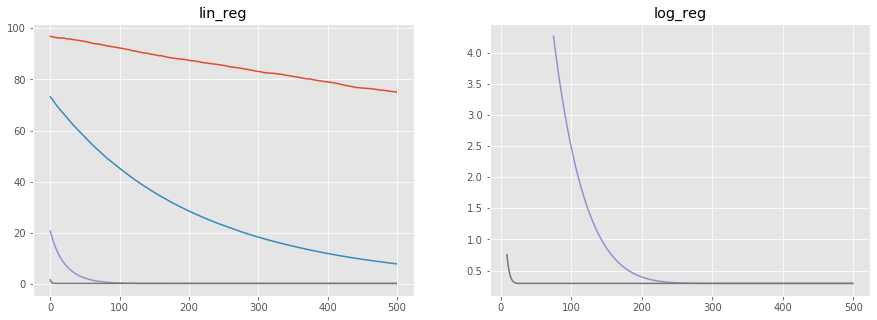

In [19]:
N = 100
batch_size = 200
max_epoch = 100
C = 1

fig = plt.figure(figsize=(15,5))

for i, model_type in enumerate(['lin_reg', 'log_reg']):
    
    ax = fig.add_subplot(1, 2, i+1)
    ax.set_title(model_type)
    alphas = [0.0001, 0.001, 0.01, 0.1]
    for alpha in alphas:
        clf = MySGDClassifier(batch_generator, C=C, alpha=alpha, max_epoch=max_epoch, 
                                  model_type=model_type, batch_size=batch_size)
        clf.fit(X, y)
        loss_array = np.asarray(clf.errors_log["loss"])
        to_plot = [loss_array[i:i+N,:].mean() for i in range(loss_array.shape[0] // N)]
        plt.plot(to_plot, label=str(alpha))
# к сожалению, label меня игнорирует :(

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

Чем больше альфа, тем быстрее сходимость

Изобразите график среднего значения весов для обеих регрессий в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

По выведенным мной формулам веса изменяются вот так:

 $$ w_{new} = w_{old} \left( 1 - \dfrac{2\alpha}{C} \right) - ... $$

Значит, при уменьшении С веса будут уменьшаться сильнее. На графике ожидаем увидеть увеличение весов с увеличением С.

/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in square
/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in true_divide
/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log
/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in multiply
/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in subtract


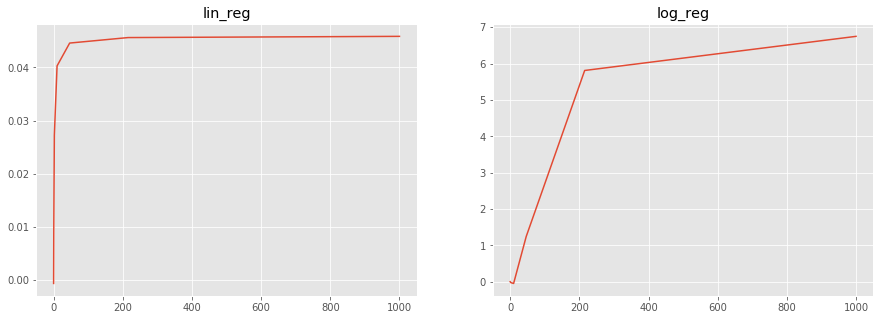

In [20]:
batch_size = 200
max_epoch = 10
C_range = np.logspace(3, -3, 10)

fig = plt.figure(figsize=(15,5))

for i, model_type in enumerate(['lin_reg', 'log_reg']):
    
    ax = fig.add_subplot(1, 2, i+1)
    ax.set_title(model_type)
    
    mean_weights = []
    for C in C_range:
        clf = MySGDClassifier(batch_generator, C=C, alpha=0.01, max_epoch=max_epoch, 
                                  model_type=model_type, batch_size=batch_size)
        clf.fit(X, y)
        mean_weight = clf.weights.mean()
        mean_weights.append(mean_weight)
    plt.plot(C_range, mean_weights, label=model_type)

Довольны ли Вы, насколько сильно уменьшились Ваши веса? 

Я довольна! 

Как я и думала, веса уменьшаются при уменьшении С.

# Боевое применение (4  балла)

**Защита данной части возможна только при преодолении в проекте бейзлайна Handmade baseline.**

Давайте применим модель на итоговом проекте! Датасет сделаем точно таким же образом, как было показано в project_overview.ipynb

Применим обе регрессии, подберем для них параметры и сравним качество. Может быть Вы еще одновременно с решением домашней работы подрастете на лидерборде!

In [21]:
doc_to_title = {}
with open('./anomaly-detection-competition-ml1-ts-spring-2020/docs_titles.tsv/docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print (len(doc_to_title))


28026


In [22]:
import pandas as pd
train_data = pd.read_csv('./anomaly-detection-competition-ml1-ts-spring-2020/train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

In [23]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from string import punctuation
from nltk.tokenize import RegexpTokenizer
import enchant

enchant_d = enchant.Dict("ru")
mystem = SnowballStemmer("russian")
russian_stopwords = stopwords.words("russian")
tokenizer = RegexpTokenizer(r'\w+')

def preprocess_text(text):
    text = ' '.join(tokenizer.tokenize(text))
    tokens = mystem.stem(text.lower()).split()
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation \
              #and enchant_d.check(token) \
              and not token.isdigit()]
    text = " ".join(tokens)
    
    return text


In [24]:
traingroups_titledata_prepr = {}
for group in traingroups_titledata.keys():
    traingroups_titledata_prepr[group] = []
    gr = traingroups_titledata[group]
    for i in gr:
        a, title, _ = i
        title = preprocess_text(title)
        traingroups_titledata_prepr[group].append((a, title,_))

In [25]:
import numpy as np
y_train = []
X_train = []
groups_train = []
for new_group in traingroups_titledata_prepr:
    docs = traingroups_titledata_prepr[new_group]
    for k, (doc_id, title, target_id) in enumerate(docs):
        y_train.append(target_id)
        groups_train.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_train.append(sorted(all_dist, reverse=True)[0:15]    )
X_train = np.array(X_train)
y_train = np.array(y_train)
groups_train = np.array(groups_train)
print (X_train.shape, y_train.shape, groups_train.shape)

(11690, 15) (11690,) (11690,)


Подберите размер батча для обучения. Линейная модель не должна учиться дольше нескольких минут. 

Не забывайте использовать скейлер!

In [26]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [27]:
skaler = StandardScaler()
X = skaler.fit_transform(X_train)

In [28]:
import time

In [29]:
batch_sizes = [50, 100, 500, 1000]
N = 100
max_epoch = 100
C = 0.001
alpha=0.01

for batch_size in batch_sizes:
    clf = MySGDClassifier(batch_generator, C=C, alpha=0.1, max_epoch=max_epoch, 
                                  model_type='log_reg', batch_size=batch_size)
    start = time.perf_counter()
    clf.fit(X, y_train)
    delta = time.perf_counter() - start
    print(f'batch_size = {batch_size}: {delta}')

/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log
/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in multiply
/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in true_divide


batch_size = 50: 1.035749390999996
batch_size = 100: 0.547586631999998
batch_size = 500: 0.30329665000000006
batch_size = 1000: 0.16805072599999704


/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in subtract


In [30]:
batch_size = 100

Разбейте данные на обучение и валидацию. Подберите параметры C, alpha, max_epoch, model_type на валидации (Вы же помните, как правильно в этой задаче делать валидацию?)

In [31]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

In [32]:
def my_cross_val_score(clf, X, y, kf):
    scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        scores.append(roc_auc_score(y_test, y_pred))
    return np.mean(scores)

In [33]:
def calc_accuracy_scores(X, y, C, alpha, max_epoch, batch_size, model_type):
    clf = MySGDClassifier(batch_generator, C=C, alpha=alpha, max_epoch=max_epoch, 
                          model_type=model_type, batch_size=batch_size)
    
    kf=KFold(n_splits=3, shuffle=True, random_state=42)
    score = np.mean(my_cross_val_score(clf, X, y, kf=kf))
    
    return score

In [34]:
C_val = np.logspace(3, -3, 10)[-4:]
alpha_val = [0.001, 0.01, 0.1]
max_epoch_val = [10, 50, 100, 200]
model_type_val = ['lin_reg', 'log_reg']
batch_size = 100

max_score = 0
best_clf = 'ups'
clf_dict = {}

for C in C_val:
    for alpha in alpha_val:
        for max_epoch in max_epoch_val:
            for model_type in model_type_val:
                
                curr_clf = f'C:{C},alpha:{alpha},max_epoch:{max_epoch},model_type:{model_type}'
                try:
                    curr_score = calc_accuracy_scores(X, y_train, C, alpha, max_epoch, batch_size, model_type)
                except:
                    curr_score = 0
                
                if curr_score >= max_score:
                    max_score = curr_score
                    best_clf = curr_clf
                clf_dict[curr_clf] = curr_score

/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log
/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in multiply
/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log
/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in multiply
/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log
/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in multiply
/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log
/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invali

/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log
/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in multiply
/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log
/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in multiply
/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log
/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in multiply
/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in square
/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by

/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log
/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in multiply
/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log
/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in multiply
/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log
/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in multiply
/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log
/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invali

/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log
/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in multiply
/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log
/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in multiply
/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log
/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in multiply
/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log
/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invali

In [35]:
best_clf

'C:0.1,alpha:0.001,max_epoch:10,model_type:lin_reg'

In [36]:
{k: v for k, v in sorted(clf_dict.items(), key=lambda item: item[1],reverse=True)}

{'C:0.1,alpha:0.001,max_epoch:10,model_type:lin_reg': 0.8435197309538487,
 'C:0.004641588833612782,alpha:0.001,max_epoch:10,model_type:lin_reg': 0.8435115113869863,
 'C:0.004641588833612782,alpha:0.001,max_epoch:50,model_type:lin_reg': 0.8435115113869863,
 'C:0.004641588833612782,alpha:0.001,max_epoch:100,model_type:lin_reg': 0.8435115113869863,
 'C:0.004641588833612782,alpha:0.001,max_epoch:200,model_type:lin_reg': 0.8435115113869863,
 'C:0.021544346900318867,alpha:0.01,max_epoch:10,model_type:lin_reg': 0.8435026967173197,
 'C:0.021544346900318867,alpha:0.01,max_epoch:50,model_type:lin_reg': 0.8435026967173197,
 'C:0.021544346900318867,alpha:0.01,max_epoch:100,model_type:lin_reg': 0.8435026967173197,
 'C:0.021544346900318867,alpha:0.01,max_epoch:200,model_type:lin_reg': 0.8435026967173197,
 'C:0.1,alpha:0.001,max_epoch:50,model_type:lin_reg': 0.8434958717325194,
 'C:0.1,alpha:0.001,max_epoch:100,model_type:lin_reg': 0.8434958717325194,
 'C:0.1,alpha:0.001,max_epoch:200,model_type:lin_

Подберите порог линейной модели, по достижении которого, Вы будете относить объект к классу 1. Вспомните, какую метрику мы оптимизируем в соревновании.  Как тогда правильно подобрать порог?

Я подумала и решила из тех графиков, которые строила до этого, что лучше поставить alpha = 0.01. И C мне больше понравился в 0.021544346900318867

In [37]:
best_alpha = 0.01
best_model_type = 'log_reg'
best_C = 0.021544346900318867
best_max_epoch = 50

In [38]:
def f1_cross_val_score(clf, X, y, kf, threshold):
    scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        scores.append(f1_score(y_test, y_pred > threshold))
    return np.mean(scores)

In [39]:
def f1_calc_accuracy_scores(X, y, C, alpha, max_epoch, batch_size, model_type, threshold):
    clf = MySGDClassifier(batch_generator, C=C, alpha=alpha, max_epoch=max_epoch, 
                          model_type=model_type, batch_size=batch_size)
    
    kf=KFold(n_splits=3, shuffle=True, random_state=42)
    score = np.mean(f1_cross_val_score(clf, X, y, kf, threshold))
    
    return score

In [40]:
clf = MySGDClassifier(batch_generator, C=best_C, alpha=best_alpha, max_epoch=best_max_epoch, 
                          model_type=best_model_type, batch_size=batch_size)
    

In [41]:
clf.fit(X, y_train)

/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log


MySGDClassifier(C=0.021544346900318867, alpha=0.01,
                batch_generator=<function batch_generator at 0x91f3d7d08>,
                batch_size=100, max_epoch=50, model_type='log_reg')

In [42]:
y_pr = clf.predict(X)

In [43]:
y_pr

array([0.50608065, 0.52553867, 0.50826523, ..., 0.48894464, 0.49016912,
       0.48975312])

In [44]:
import seaborn as sns

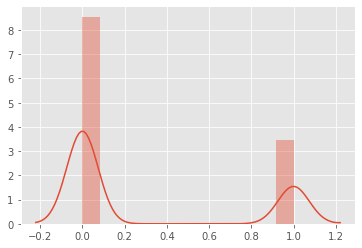

In [45]:
sns.distplot(y_train)

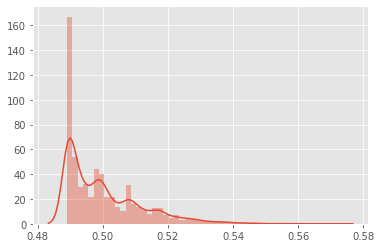

In [46]:
sns.distplot(y_pr)

In [47]:
best_threshold = 0
best_score = 0

threshold_dict = {}

for threshold in np.linspace(0.48, 0.54, 10):
    curr_score = f1_calc_accuracy_scores(X, y_train, best_C, best_alpha, 
                                      best_max_epoch, batch_size, best_model_type, threshold)
    
    threshold_dict[threshold] = curr_score
    if curr_score > best_score:
        best_score = curr_score
        best_threshold = threshold

/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log


In [48]:
best_score

0.6681511917310181

In [49]:
best_threshold

0.5

In [50]:
best_threshold = 0.5

С лучшими параметрами на валидации сделайте предсказание на тестовом множестве, отправьте его на проверку на платформу kaggle. Убедитесь, что Вы смогли побить public score первого бейзлайна.

** При сдаче домашки Вам необходимо кроме ссылки на ноутбук показать Ваш ник на kaggle, под которым Вы залили решение, которое побило Handmade baseline. **

In [51]:
doc_to_title = {}
with open('./anomaly-detection-competition-ml1-ts-spring-2020/docs_titles.tsv/docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print (len(doc_to_title))

28026


In [52]:
import pandas as pd
test_data = pd.read_csv('./anomaly-detection-competition-ml1-ts-spring-2020/test_groups.csv')
testgroups_titledata = {}
for i in range(len(test_data)):
    new_doc = test_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    title = doc_to_title[doc_id]
    if doc_group not in testgroups_titledata:
        testgroups_titledata[doc_group] = []
    testgroups_titledata[doc_group].append((doc_id, title))

In [53]:
testgroups_titledata_prepr = {}
for group in testgroups_titledata.keys():
    testgroups_titledata_prepr[group] = []
    gr = testgroups_titledata[group]
    for i in gr:
        a, title = i
        title = preprocess_text(title)
        testgroups_titledata_prepr[group].append((a, title))

In [54]:
import numpy as np
X_test = []
groups_test = []
for new_group in testgroups_titledata_prepr:
    docs = testgroups_titledata_prepr[new_group]
    for k, (doc_id, title) in enumerate(docs):
        groups_test.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_test.append(sorted(all_dist, reverse=True)[0:15]    )
X_test = np.array(X_test)

groups_test = np.array(groups_test)
print (X_test.shape, groups_test.shape)

(16627, 15) (16627,)


In [55]:
my_clf = MySGDClassifier(batch_generator, C=best_C, alpha=best_alpha, max_epoch=best_max_epoch, 
                          model_type=best_model_type, batch_size=batch_size)

In [56]:
my_clf.fit(X, y_train)

/Users/daria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log


MySGDClassifier(C=0.021544346900318867, alpha=0.01,
                batch_generator=<function batch_generator at 0x91f3d7d08>,
                batch_size=100, max_epoch=50, model_type='log_reg')

In [57]:
my_clf.weights

array([0.00252487, 0.00346358, 0.00365351, 0.00352185, 0.00360878,
       0.00363552, 0.00346687, 0.00321857, 0.00315549, 0.00313583,
       0.00317146, 0.00324264, 0.00321817, 0.00321252, 0.0031773 ])

In [58]:
X_test = skaler.fit_transform(X_test)
y_test = np.asarray(my_clf.predict(X_test) > best_threshold, dtype=int)

In [59]:
test_data['target'] = y_test

In [60]:
test_data[['pair_id', 'target']].to_csv('lets_try.csv', index=False)

Побила не только Handmade, но и ML baseline :)

sad_simulacrum

# Фидбек (бесценно)

* Какие аспекты обучения линейных моделей Вам показались непонятными? Какое место стоит дополнительно объяснить?

***Ваше ответ здесь***

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***